In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit

In [67]:
a = np.random.randn(1000)

In [69]:
%%timeit
b = np.roll(a,-1)
b[-1] = 1.

17.7 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [70]:
%%timeit
a[:-1] = a[1:]
a[-1] = 1.

1.25 µs ± 10.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [3]:
k = 3
tau = 0.1
D = 1e-6
s = np.sqrt(2*D)
max_t = 5
dt = 2e-2
dx = 1e-4
border = 0.001

ntau = round(tau/dt)
ts = np.arange(0,max_t,dt)
ts_r = ts[1:]
x_s = np.arange(-0.003,0.003,dx)
bins = np.arange(-0.003-dx/2,0.003+dx/2,dx)

N_t = len(ts)
N_x = len(x_s)

s = np.sqrt(2*D)

def cusp_force(x,x_min):
    if x < 0:
        return -k*(x+x_min)
    else:
        return -k*(x-x_min)
cusp_force = np.vectorize(cusp_force)

def harmonic(x):
    return -k*x

# Solve as 1 dimensonal

In [175]:
R = np.zeros(( N_x, N_x))


F = harmonic(x_s)
Fm = (F[1:]+F[:-1])/2
lp = D / dx**2 * np.exp((Fm*dx/D)/2)  # r_i->i+1
ln = D / dx**2 * np.exp(-(Fm*dx/D)/2)  # r_i+1->i

def get_prop(x):
    R[0,0] = -lp[x]
    R[-1,-1] = -ln[x]
    R[np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[x]+ln[x]) # -(r_i->i+1 + r_i->i-1) ????
    R[np.arange(0,N_x-1),np.arange(1,N_x)] = ln[x]
    R[np.arange(1,N_x),np.arange(0,N_x-1)] = lp[x]
    prop = expm(R*dt)
    return prop

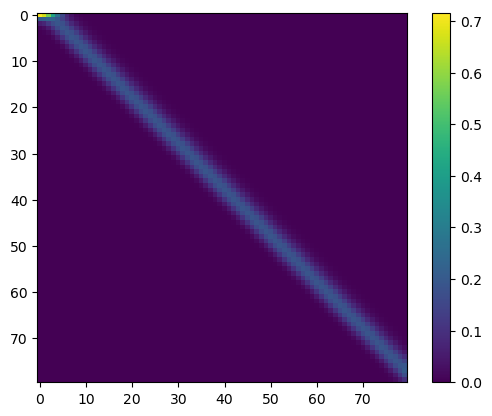

In [4]:
plt.imshow(get_prop(78))
plt.colorbar()

In [5]:
i_zero = np.argmin(x_s**2)

In [6]:
len(x_s)

80

In [7]:
ntau

5

In [44]:
# states = np.array([
# [40, 40, 40, 40, 40, 40],
# [20, 40, 40, 40, 40, 60]
# ])
# probs = [0.5,0.5]

In [135]:
states = np.full((1,ntau+1),i_zero,dtype=int)
probs = [1]

for i in tqdm(np.arange(7)):
    res_state = []
    new_states = []
    new_probs = []
    print('-------')
    for p,state in zip(probs, states):
        prob = get_prop(state[0])
        encoded_state = np.zeros(N_x, dtype = float)
        encoded_state[state[-1]] = 1
        #this_probs = (prob@encoded_state.T).T*p
        #i_s = np.where(this_probs > 0.0001)
        this_probs = (prob@encoded_state.T).T
        i_s = np.where(this_probs > 0.01)
        this_probs = this_probs[i_s]
        this_probs = this_probs/this_probs.sum()*p
        this_new_states = np.repeat(np.roll(state,-1)[None,:],len(i_s[0]),axis = 0)
        this_new_states[:,-1] = i_s[0]

        new_probs.extend(this_probs)
        new_states.extend(this_new_states)
    
    states = new_states
    probs = new_probs/np.sum(new_probs)

  0%|          | 0/7 [00:00<?, ?it/s]

-------
-------
-------
-------
-------
-------
-------


In [136]:
len(states), probs

(5196312,
 array([9.07143893e-12, 2.25279115e-11, 4.56890790e-11, ...,
        3.08140964e-11, 1.49673029e-11, 5.93723693e-12]))

In [137]:
np.sum(new_probs),np.sum(probs)

(0.9999999999999998, 0.9999999999999998)

In [138]:
final_state = np.stack(states)

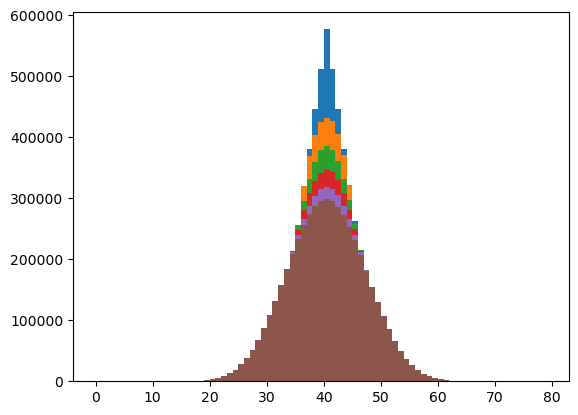

In [140]:
for fr in final_state.T:
    plt.hist(fr, bins = np.arange(0,N_x))
plt.show()

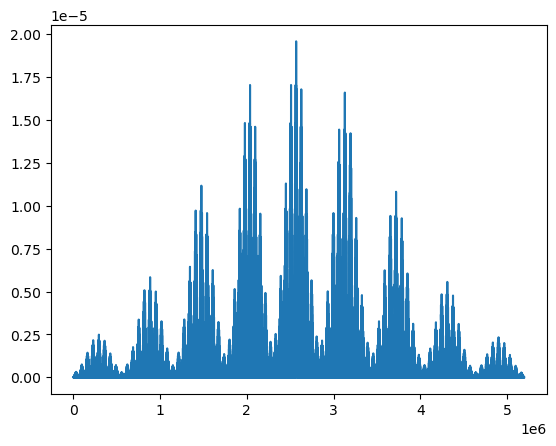

In [142]:
plt.plot(probs)

In [145]:
with open('nummeric_results/2d-algo.pkl', 'wb') as f:
    pickle.dump({'probs':probs,'final_state':final_state},f)

In [150]:
np.unique([[1,1,2],[1,1,3],[1,1,2]], axis = 0)

array([[1, 1, 2],
       [1, 1, 3]])

In [151]:
uni = np.unique(final_state, axis = 0)

In [152]:
len(uni)

1154736

In [154]:
len(final_state)/len(uni)

4.5

# Solve as two dimensional

In [4]:
# x(t-tau), x(t), res
R = np.zeros(( N_x,N_x, N_x))


F = harmonic(x_s)
#Fm = (F[1:]+F[:-1])/2
lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i


R[:,0,0] = -lp
R[:,-1,-1] = -ln
R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
prop = expm(R*dt, )
#    return prop

In [23]:
i_zero = np.argmin(x_s**2)
states = np.full((1,ntau+1),i_zero,dtype=int)
probs = np.array([1.])

# states = np.array([
# [40, 40, 40, 40, 40, 40],
# [10, 40, 40, 40, 40, 60]
# ])
# probs = [0.5,0.5]

for i in tqdm(np.arange(9)):
    #encoded_states = np.zeros((len(states),N_x,N_x), dtype = float)
    #encoded_states[np.arange(len(states)),states[:,0],states[:,-1]] = 1.
    #a_s = np.empty((len(states), N_x), dtype=float)
    #for i in range(len(encoded_states)//batch_size+1):
    a_s = np.swapaxes(prop,1,2)[states[:,0],states[:,-1],:]
    
    #res_state = []
    #new_states = []
    #new_probs = []

    print('-------')
    
    i_s = np.where(a_s*probs[:,None] > 0.000001)
    new_probs = a_s[i_s]*probs[i_s[0]]
    new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
    print(new_states.shape)
    new_states[:,:-1] = new_states[:,1:]
    new_states[:,-1]  = i_s[1]
    #this_probs = this_probs/this_probs.sum()*p
#     for p,state,a in zip(probs, states, a_s):
#         i_s = np.where(a*p > 0.000001)
#         #i_s = np.where(a > 0.01)
#         this_probs = a[i_s]
#         this_probs = this_probs/this_probs.sum()*p
#         this_new_states = np.repeat(np.roll(state,-1)[None,:],len(i_s[0]),axis = 0)
#         this_new_states[:,-1] = i_s[0]

#         new_probs.extend(this_probs)
#         new_states.extend(this_new_states)
    
    uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
    states = uni
    #new_probs = np.stack(new_probs)
    new_probs = np.stack([np.sum(new_probs[indxs == i]) for i in range(len(uni))])
    probs = new_probs/np.sum(new_probs)
    print(len(probs))

  0%|          | 0/9 [00:00<?, ?it/s]

-------
(23, 6)
23
-------
(305, 6)
305
-------
(2871, 6)
2871
-------
(18201, 6)
18201
-------
(77415, 6)
77415
-------
(186289, 6)
186289
-------
(234633, 6)
75593
-------
(283955, 6)
85043
-------
(283925, 6)
83559


In [24]:
states[len(states)//2-10:len(states)//2+10]

array([[30, 30, 30, 30, 29, 29],
       [30, 30, 30, 30, 29, 30],
       [30, 30, 30, 30, 29, 31],
       [30, 30, 30, 30, 29, 32],
       [30, 30, 30, 30, 29, 33],
       [30, 30, 30, 30, 30, 25],
       [30, 30, 30, 30, 30, 26],
       [30, 30, 30, 30, 30, 27],
       [30, 30, 30, 30, 30, 28],
       [30, 30, 30, 30, 30, 29],
       [30, 30, 30, 30, 30, 30],
       [30, 30, 30, 30, 30, 31],
       [30, 30, 30, 30, 30, 32],
       [30, 30, 30, 30, 30, 33],
       [30, 30, 30, 30, 30, 34],
       [30, 30, 30, 30, 30, 35],
       [30, 30, 30, 30, 31, 27],
       [30, 30, 30, 30, 31, 28],
       [30, 30, 30, 30, 31, 29],
       [30, 30, 30, 30, 31, 30]])

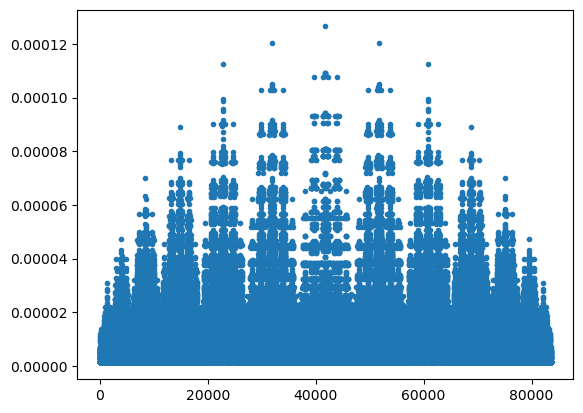

In [25]:
plt.plot(probs,'.')

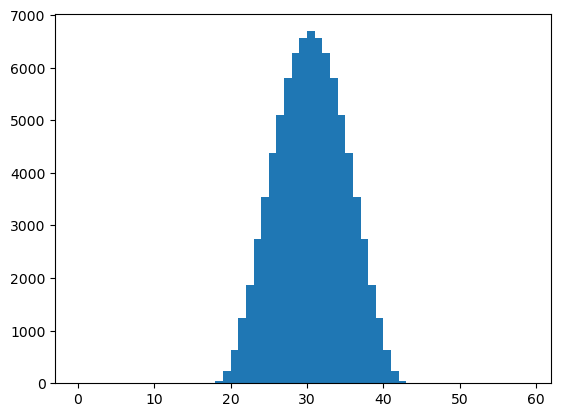

In [26]:
plt.hist(states[:,-1], bins = np.arange(0,N_x))
plt.show()

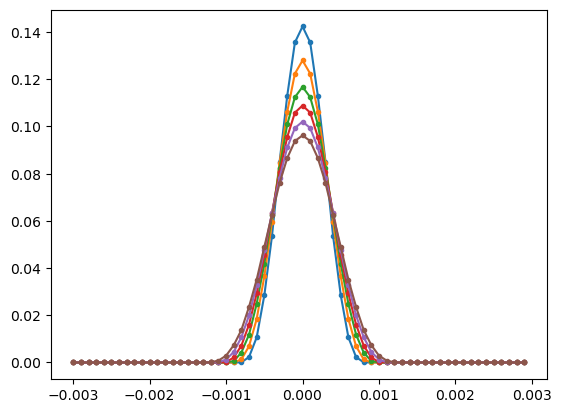

In [27]:
cum_probs = np.stack([[np.sum(probs[states[:,j] == i]) for i in range(N_x)] for j in range(ntau+1)])
for j in range(ntau+1):
    plt.plot(x_s,cum_probs[j],'.-')